In [14]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches

import os
os.makedirs("../out", exist_ok=True)

from tqdm import tqdm

## Q1.2: Lucas-Kanade Tracking

Make sure to comment your code and use proper names for your variables. 

In [15]:
# We recommend using this function, but you can explore other methods as well (e.g., ndimage.shift).
from scipy.interpolate import RectBivariateSpline

# The function below could be useful as well :) 
from numpy.linalg import lstsq

def LucasKanade(It, It1, rect, threshold, num_iters, p0=np.zeros(2)):
    """
    :param[np.array(H, W)] It   : Image frame at time-step t
    :param[np.array(H, W)] It1  : Image frame at time-step t+1
    :param[np.array(4, 1)] rect : Coordinates of template which has the form [x1, y1, x2, y2], where
                                  [x1, y1] is the top-left, and [x2, y2] is the bottom-right corner.  
    :param[float] dp_thresh     : If the length of dp < threshold, terminate the optimization
    :param[int] num_iters       : Number of iterations for running the optimization
    :param[np.array(2, 1)] p0   : Initial movement vector [dp_x0, dp_y0]

    :return[np.array(2, 1)] p   : Final movement vector [dp_x, dp_y]
    """
	
    # Initialize p to p0. Don't remove these lines.
    p = p0
    delta_p = np.ones((1,2))

    # ----------------------------------------------------------------------------------------------
    # TODO: Add your LK implementation here: 

    # infor: w and h
    w = int(np.round(rect[2] - rect[0] + 1))
    h = int(np.round(rect[3] - rect[1] + 1))
    # Use whole img to build mode:
    h_all=np.arange(0,It.shape[0])
    w_all=np.arange(0,It.shape[1])

    # build mode for interpolation of It, It1
    mode = RectBivariateSpline(h_all, w_all, It)
    mode1 = RectBivariateSpline(h_all, w_all, It1)

    # index for stop loop
    times = 0
    # values in template, rectangle is inclusive
    temp_x=np.arange(rect[0],rect[2]+1)[:w]
    temp_y=np.arange(rect[1],rect[3]+1)[:h]

    # get interpolation value of template from mode
    template = mode(temp_y,temp_x)

    # compare with threshold
    delta_threshold=delta_p[0][0]**2 + delta_p[0][1]**2

    # incase input get changed, make a copy
    rect1= np.copy(rect).astype(float)

    while ( delta_threshold>= threshold) and (times<num_iters):
        # 1. Warp the template;
        # update rect
        rect1[0] = p[0] + rect[0]
        rect1[1] = p[1] + rect[1]
        rect1[2] = p[0] + rect[2]
        rect1[3] = p[1] + rect[3]

        # 2. Build your linear system (Q1.1.2);
        # get img of X' using interpolation
        x1=np.arange(rect1[0],rect1[2]+1)[:w]
        y1=np.arange(rect1[1],rect1[3]+1)[:h]

        # get new image values with interpolation
        new_img = mode1(y1,x1)

        # get b: n*1
        b_temp = template.reshape(-1,1)
        b_new_img=new_img.reshape(-1,1)
        b=b_temp-b_new_img
        # get A: n*2
        A=np.zeros((w*h,2))

        # gradient in x and y direction, derivative=1
        gradient_x=mode1(y1, x1, dy=1)
        gradient_x=gradient_x.reshape(1,-1)
        gradient_y=mode1(y1, x1, dx=1) 
        gradient_y=gradient_y.reshape(1,-1)
        # append to A
        A[:,0]=gradient_x[0]
        A[:,1]=gradient_y[0]

        # 3. Run least-squares optimization (eq. (1.4));
        delta_p=np.linalg.lstsq(A, b, rcond=None)[0]

        # 4. Update the local motion.
        p[0]+=delta_p[0]
        p[1]+=delta_p[1]
        #print(p,delta_p)

        delta_threshold=delta_p[0]**2 + delta_p[1]**2
        times+=1

    
    # ----------------------------------------------------------------------------------------------
    return p

### Debug Q1.2 

A few tips to debug your implementation:
- You can use the short snippet of code below to test if you get reasonable results. The snippet simply 
checks visualizes the resulting p from running LK on a single frame. You should be able to see a slight shift in the template. 

- You may also want to visualize the image gradients you compute within your LK implementation

- Plot iterations vs the norm of delta_p

86.0 35.0
[ 5.37548268 23.6361486 ]


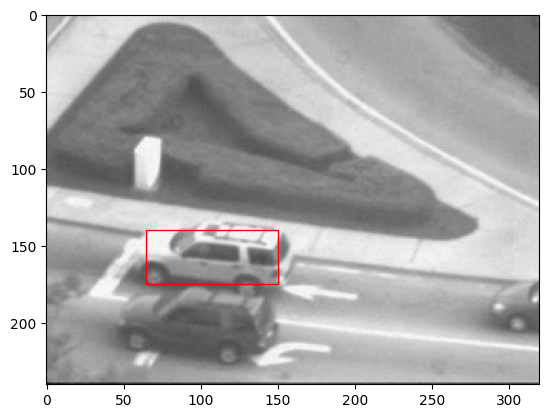

In [16]:
num_iters = 1000
threshold = 0.01
seq = np.load("../data/carseq.npy")
rect = [59.0, 116.0, 145.0, 151.0]
It = seq[:,:,0]
w = rect[2] - rect[0]
h = rect[3] - rect[1]
print(w, h)

# Initial frame
plt.figure()
currentAxis = plt.gca()
# rect_draw_It1 = patches.Rectangle((rect[0], rect[1]), w, h, linewidth=1, edgecolor='r', facecolor='none')
# currentAxis.add_patch(rect_draw_It1)

# TODO: run LK and update template and plot 
# ----------------------------------------------------------------------------------------------
It1  = seq[:,:,25]
p = LucasKanade(It, It1, rect, threshold, num_iters, p0=np.zeros(2))
print(p)
rect_draw_It1 = patches.Rectangle((rect[0]+p[0], rect[1]+p[1]), w, h, linewidth=1, edgecolor='r', facecolor='none')
currentAxis.add_patch(rect_draw_It1)
plt.imshow(It1, cmap='gray')
plt.show()
# ----------------------------------------------------------------------------------------------

## Q1.3: Track Sequence

In [17]:
def TrackSequence(seq, rect, num_iters, threshold):
    """
    :param[np.array(H, W, N)] seq : sequence of frames
    :param[np.array(4, 1)] rect   : Coordinates of template which has the form [x1, y1, x2, y2], where
                                    [x1, y1] is the top-left, and [x2, y2] is the bottom-right corner.  
    :param[int] num_iters         : Number of iterations for running the optimization
    :param[float] dp_thresh       : If the length of dp < threshold, terminate the optimization

    :return[np.array(N, 4)] rects : Coordinates for the template at each frame in the sequence.
    """
    H, W, N = seq.shape

    rects =[rect]
    It = seq[:, :, 0]
        
    # ----------------------------------------------------------------------------------------------
    # TODO: Iterate over the sequence to track the object in of interest. Add your code here:
    for i in tqdm(range(1, N)):
        p = LucasKanade(seq[:,:,i-1], seq[:,:,i], rect, threshold, num_iters, p0=np.zeros(2))
        #print(p)
        rect_new=np.copy(rect)
        rect_new[0] += p[0]
        rect_new[1] += p[1]
        rect_new[2] += p[0]
        rect_new[3] += p[1]
        # print(rect_new,p)
        rects.append(rect_new)
        rect=rect_new
        #pass

    # ----------------------------------------------------------------------------------------------
        
    rects = np.array(rects)
    print(rects.shape)
    
    # Just a sanity check
    assert rects.shape == (N, 4), f"Your output sequence {rects.shape} is not {N}x{4}"
    return rects

### Q1.3: Track Car Sequence

Feel free to play with these snippets of code; run ablations, visualize a gif with the whole sequence, etc.

Just make sure the bounding boxes for the car are clearly visible, and report those of the frames we requested. 

In [18]:
seq = np.load("../data/carseq.npy")

# TODO: update
rect = [59.0, 116.0, 145.0, 151.0]

# NOTE: these are default parameters. Once your code works, you're encouraged to play with them by
# running ablations, and report your best results. 
num_iters = 1e4
threshold = 1e-2

rects = TrackSequence(seq, rect, num_iters, threshold)
np.save(f'../out/carseqrects.npy', rects)

100%|██████████| 414/414 [00:10<00:00, 37.82it/s]

(415, 4)


[ 59.40128908 117.12893963 145.40128908 152.12893963]
[206.02672444 186.5562702  292.02672444 221.5562702 ]
[119.36751864 142.09782308 205.36751864 177.09782308]
[190.26332576 123.33563642 276.26332576 158.33563642]
[ 69.56898102 138.72016178 155.56898102 173.72016178]


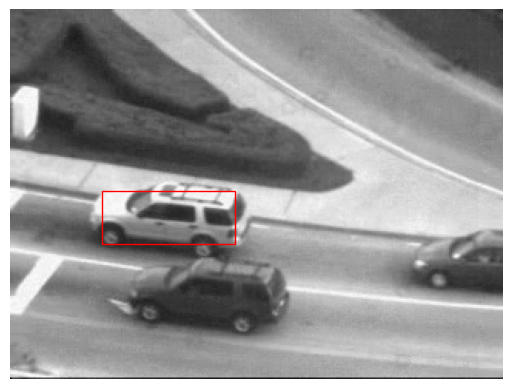

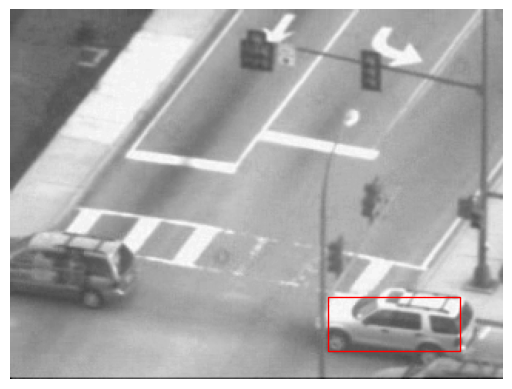

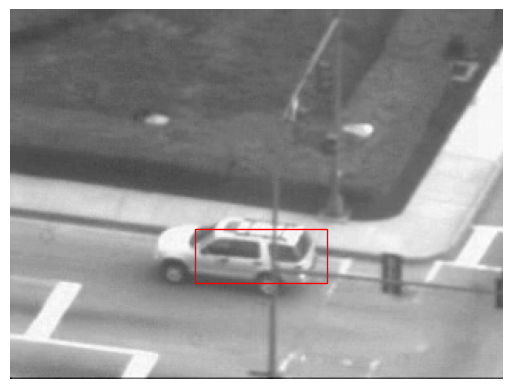

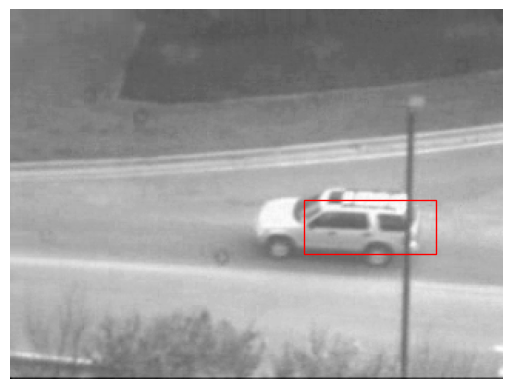

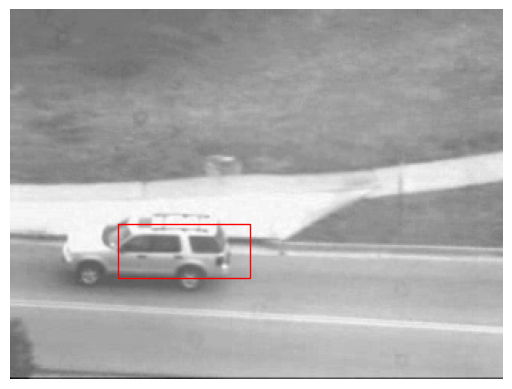

In [19]:
# TODO: visualize. You can make this into a function to re-use it for other visualization questions. 
# List of frames to save
seq = np.load("../data/carseq.npy")
frames_to_save =   [1, 80, 160, 280, 410]
rects = np.load("../out/carseqrects.npy")

for idx in frames_to_save:
    # NOTE: here's an example on how to visualize a frame with its template. 
    frame = seq[:,:,idx]
    rect = rects[idx]
    w = rect[2] - rect[0]
    h = rect[3] - rect[1]
    plt.figure()
    axis = plt.gca()
    #print(rect[0], rect[1])
    rect_draw = patches.Rectangle((rect[0], rect[1]), w, h, linewidth=1, edgecolor='r', facecolor='none')
    axis.add_patch(rect_draw)
    plt.imshow(frame, cmap='gray')
    plt.axis('off')
    plt.savefig(f"../out/sol_1.3_carseq_{idx+1}.png")
    print(rect)


### Q1.3: Test Girl Sequence

Same drill as with the car sequence. 

In [20]:
seq = np.load("../data/girlseq.npy")

# TODO: update
rect = [280.0, 152.0, 330.0, 318.0]

# NOTE: these are default parameters. Once your code works, you're encouraged to play with them by
# running ablations, and report your best results. 
num_iters = 1e4
threshold = 1e-2

rects = TrackSequence(seq, rect, num_iters, threshold)
np.save(f'../out/girlseqrects.npy', rects)

100%|██████████| 89/89 [00:09<00:00,  9.03it/s]

(90, 4)


[280.58179593 152.88816916 330.58179593 318.88816916]
[290.90378274 156.54468375 340.90378274 322.54468375]
[296.16722369 162.74346042 346.16722369 328.74346042]
[281.69250735 166.18142536 331.69250735 332.18142536]
[312.38775003 172.83098904 362.38775003 338.83098904]


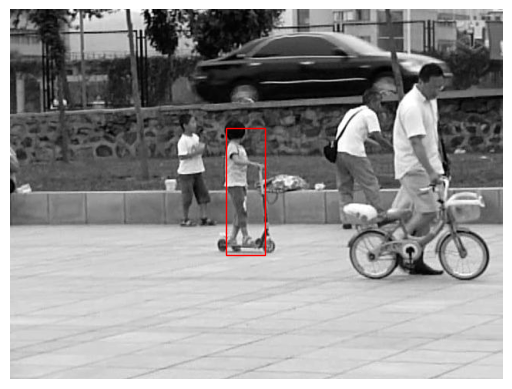

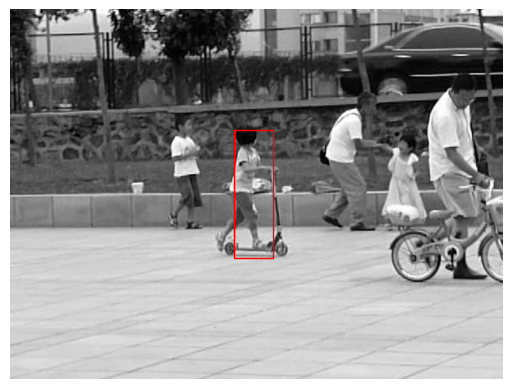

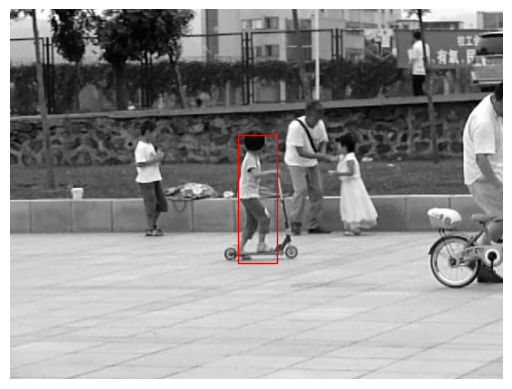

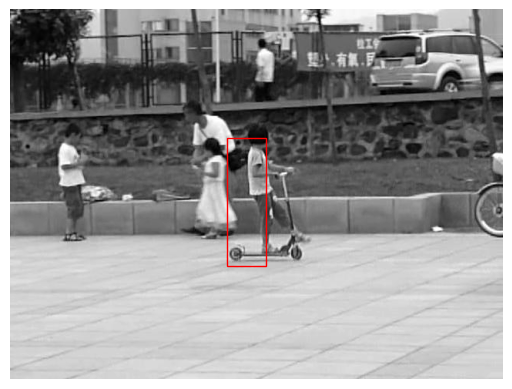

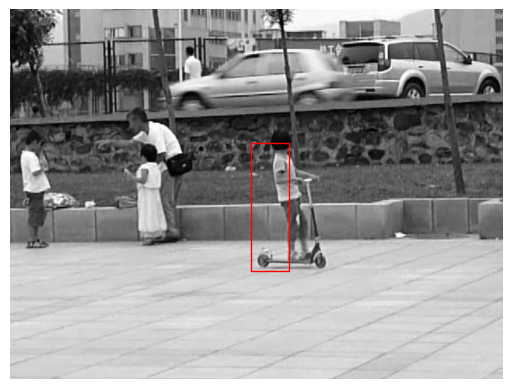

In [21]:
# TODO: visualize. You can copy-and-paste your visualization code from before (or re-use the function)
frames_to_save =  [1, 15, 35, 65, 85]
rects = np.load("../out/girlseqrects.npy")
seq = np.load("../data/girlseq.npy")

for idx in frames_to_save:
    #pass
    
    #NOTE: here's an example on how to visualize a frame with its template. 
    frame = seq[:,:,idx]
    rect = rects[idx]
    w = rect[2] - rect[0]
    h = rect[3] - rect[1]
    plt.figure()
    axis = plt.gca()
    rect_draw = patches.Rectangle(
        (rect[0], rect[1]), w, h, linewidth=1, edgecolor='r', facecolor='none')
    axis.add_patch(rect_draw)
    plt.imshow(frame, cmap='gray')
    plt.axis('off')
    plt.savefig(f"../out/sol_1.3_girlseq_{idx+1}.png")
    print(rect)

## Q1.4: Tracking with Template Correction 

In [22]:
def TrackSequenceWithTemplateCorrection(seq, rect_0, num_iters, lk_threshold, drift_threshold):
    """
    :param[np.array(H, W, N)] seq : sequence of frames
    :param[np.array(4, 1)] rect   : Coordinates of template which has the form [x1, y1, x2, y2], where
                                    [x1, y1] is the top-left, and [x2, y2] is the bottom-right corner.  
    :param[int] num_iters         : Number of iterations for running the optimization
    :param[float] dp_thresh       : If the length of dp < threshold, terminate the optimization
    :param[float] drift_threshold : float, threshold for the template update.

    :return[np.array(N, 4)] rects : Coordinates for the template at each frame in the sequence.
    """
    H, W, N = seq.shape
    rect = np.copy(rect_0)
    rects_wtcr =[]
    
    It = seq[:,:,0]
    It0 = seq[:,:,0]

    # ----------------------------------------------------------------------------------------------
    # TODO: Iterate over the sequence to track the object in of interest and do template correction.
    #  Add your code here:
    rects_wtcr.append(rect)
    # initial p
    pn=np.zeros(2)

    # initial rect
    rect_it=np.copy(rect_0)
    rect_it0=np.copy(rect_0)

    for i in tqdm(range(1, N)):
        # first formula: starts with pn-1, use Tn as tmplate
        pn = LucasKanade(It, seq[:,:,i], rect_it, lk_threshold, num_iters, p0=np.copy(pn))
        # append result to results list
        rect_new=np.copy(rect_it)
        rect_new[0] += pn[0]
        rect_new[1] += pn[1]
        rect_new[2] += pn[0]
        rect_new[3] += pn[1]
        rects_wtcr.append(rect_new)
        # update method
        # second formula, start with pn, use T1 as tmplate
        pn_star=LucasKanade(It0, seq[:,:,i], rect_it0, lk_threshold, num_iters, p0=np.copy(pn))
        # update with p_star
        p_diff = pn_star-pn
        # if '<', use pn_star and this frame
        if np.linalg.norm(p_diff) <= drift_threshold:
            rect_it=np.copy(rect_it0)
            rect_it[0] += pn_star[0]
            rect_it[1] += pn_star[1]
            rect_it[2] += pn_star[0]
            rect_it[3] += pn_star[1]
            It=seq[:,:,i]
        else:
            # tmplate not changed, still use it and rect_it
            continue
        #pass

    # ----------------------------------------------------------------------------------------------
    
    rects_wtcr = np.array(rects_wtcr)
    # Just a sanity check
    assert rects_wtcr.shape == (N, 4), f"Your output sequence {rects_wtcr.shape} is not {N}x{4}"
    return rects_wtcr

### Q1.4: Track Car Sequence with Template Correction

Feel free to play with these snippets of code; run ablations, visualize a gif with the whole sequence, etc.

Just make sure the bounding boxes for the car are clearly visible, and report those of the frames we requested. 

In [23]:
seq = np.load("../data/carseq.npy")

# TODO: update
rect =  [59.0, 116.0, 145.0, 151.0]

# NOTE: these are default parameters. Once your code works, you're encouraged to play with them by
# running ablations, and report your best results. 
num_iters = 1e4
threshold = 1e-2
drift_threshold = 5

rects = TrackSequenceWithTemplateCorrection(seq, rect, num_iters, threshold, drift_threshold)
np.save("../out/carseqrects-wtcr.npy", rects)

100%|██████████| 414/414 [00:18<00:00, 22.55it/s]


rect:[ 59.40128908 117.12893963 145.40128908 152.12893963]
rect_wtcr:[ 59.40128908 117.12893963 145.40128908 152.12893963]
rect:[206.02672444 186.5562702  292.02672444 221.5562702 ]
rect_wtcr:[206.25204846 186.71187455 292.25204846 221.71187455]
rect:[119.36751864 142.09782308 205.36751864 177.09782308]
rect_wtcr:[101.29995648 140.64668564 187.29995648 175.64668564]
rect:[190.26332576 123.33563642 276.26332576 158.33563642]
rect_wtcr:[169.80042063 122.51810479 255.80042063 157.51810479]
rect:[ 69.56898102 138.72016178 155.56898102 173.72016178]
rect_wtcr:[ 47.49168477 137.38808432 133.49168477 172.38808432]


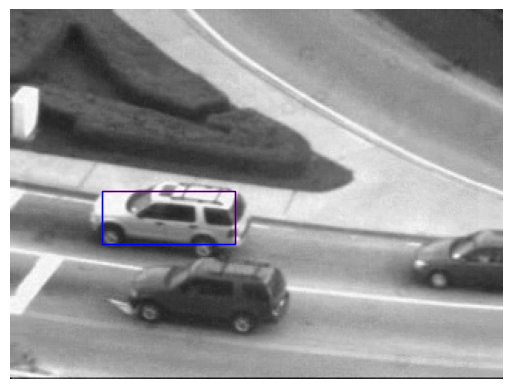

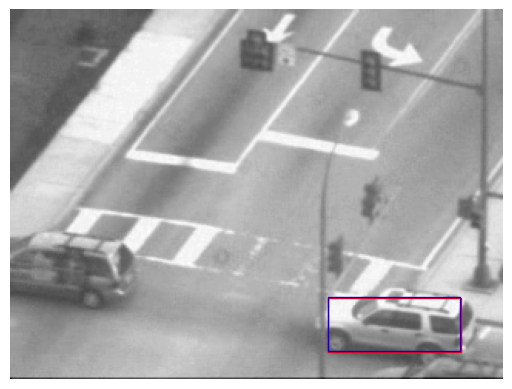

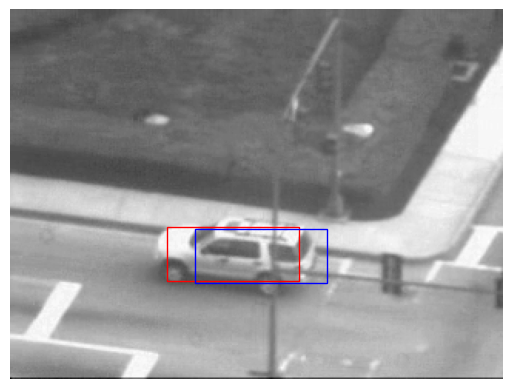

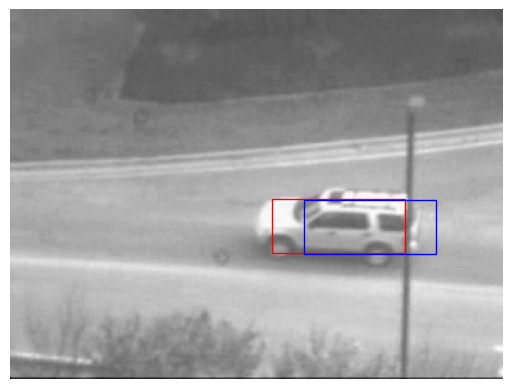

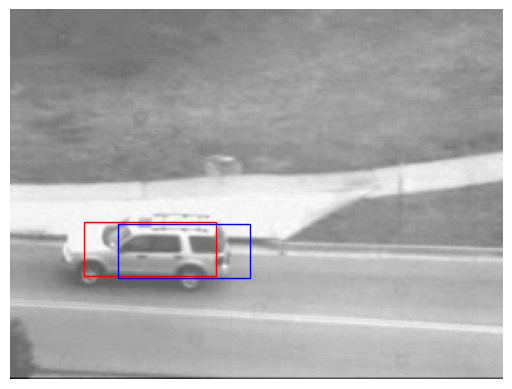

In [24]:
# TODO: visualize. An example for how to visualize the outputs
# List of frames to visualize
frames_to_save =  [1, 80, 160, 280, 410]
seq = np.load("../data/carseq.npy")

rects_wtcr = np.load("../out/carseqrects-wtcr.npy")
rects = np.load("../out/carseqrects.npy")

for idx in frames_to_save:
    #pass
    rect_wtcr = rects_wtcr[idx]
    rect = rects[idx]
    frame = seq[:,:,idx]
    w = rect[2] - rect[0]
    h = rect[3] - rect[1]

    plt.figure()
    currentAxis = plt.gca()
    rect_wcrt_draw = patches.Rectangle(
        (rect_wtcr[0], rect_wtcr[1]), w, h, linewidth=1, edgecolor='r', facecolor='none')
    currentAxis.add_patch(rect_wcrt_draw)
    
    rect_draw = patches.Rectangle(
        (rect[0], rect[1]), w, h, linewidth=1, edgecolor='b', facecolor='none')
    currentAxis.add_patch(rect_draw)
    
    plt.imshow(frame, cmap='gray')
    plt.axis('off')
    plt.savefig(f"../out/sol_1.4_carseq_{idx+1}.png")
    print("rect:"+str(rect))
    print("rect_wtcr:"+str(rect_wtcr))

### Q1.4: Track Girl Sequence with Template Correction

Feel free to play with these snippets of code; run ablations, visualize a gif with the whole sequence, etc.

Just make sure the bounding boxes for the car are clearly visible, and report those of the frames we requested. 

In [25]:
seq = np.load("../data/girlseq.npy")

# TODO: update
rect = [280.0, 152.0, 330.0, 318.0]

# NOTE: these are default parameters. Once your code works, you're encouraged to play with them by
# running ablations, and report your best results. 
num_iters = 1e4
threshold = 1e-3
drift_threshold = 3

rects = TrackSequenceWithTemplateCorrection(seq, rect, num_iters, threshold, drift_threshold)
np.save("../out/girlseqrects-wtcr.npy", rects)

100%|██████████| 89/89 [00:38<00:00,  2.30it/s]


rect:[280.58179593 152.88816916 330.58179593 318.88816916]
rect_wtcr:[280.59490183 152.89923326 330.59490183 318.89923326]
rect:[290.90378274 156.54468375 340.90378274 322.54468375]
rect_wtcr:[294.36798192 158.06902019 344.36798192 324.06902019]
rect:[296.16722369 162.74346042 346.16722369 328.74346042]
rect_wtcr:[303.56531107 164.16063632 353.56531107 330.16063632]
rect:[281.69250735 166.18142536 331.69250735 332.18142536]
rect_wtcr:[316.40983807 164.63039457 366.40983807 330.63039457]
rect:[312.38775003 172.83098904 362.38775003 338.83098904]
rect_wtcr:[340.38437912 173.84775062 390.38437912 339.84775062]


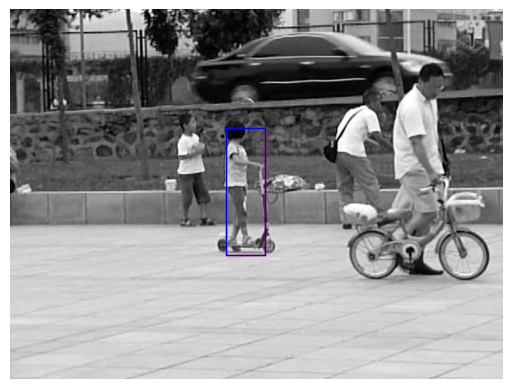

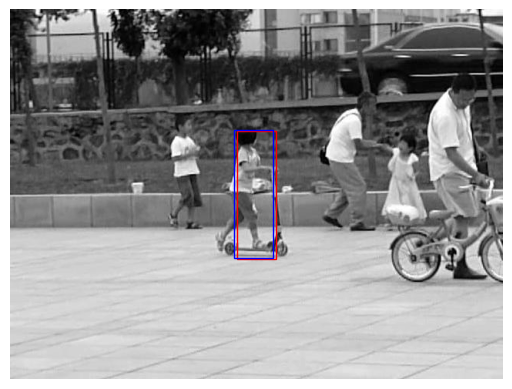

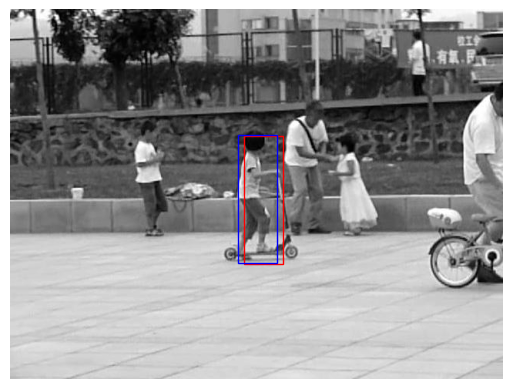

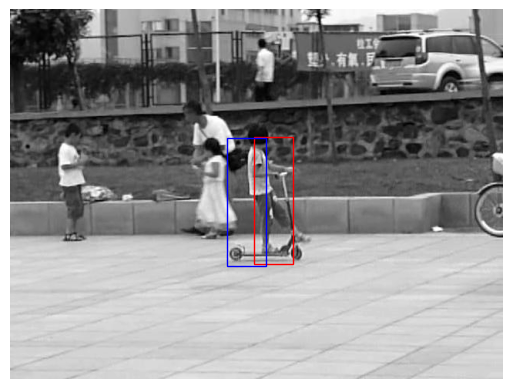

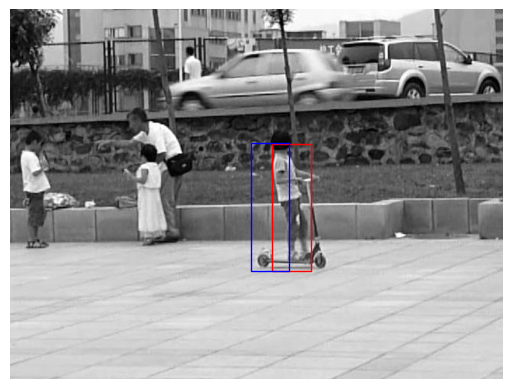

In [26]:
# TODO: visualize. An example for how to visualize the outputs
# List of frames to visualize
frames_to_save = [1, 15, 35, 65, 85]

rects_wtcr = np.load("../out/girlseqrects-wtcr.npy")
rects = np.load("../out/girlseqrects.npy")
seq = np.load("../data/girlseq.npy")

for idx in frames_to_save:
    
    rect_wtcr = rects_wtcr[idx]
    rect = rects[idx]
    frame = seq[:,:,idx]
    w = rect[2] - rect[0]
    h = rect[3] - rect[1]


    plt.figure()
    currentAxis = plt.gca()
    rect_wcrt_draw = patches.Rectangle(
        (rect_wtcr[0], rect_wtcr[1]), w, h, linewidth=1, edgecolor='r', facecolor='none')
    currentAxis.add_patch(rect_wcrt_draw)
    
    rect_draw = patches.Rectangle(
        (rect[0], rect[1]), w, h, linewidth=1, edgecolor='b', facecolor='none')
    currentAxis.add_patch(rect_draw)
    
    plt.imshow(frame, cmap='gray')
    plt.axis('off')
    plt.savefig(f"../out/sol_1.4_girlseq_{idx+1}.png")
    print("rect:"+str(rect))
    print("rect_wtcr:"+str(rect_wtcr))